#Оновные этапы:
1. Параллельно смотрел курс Джереми Ховарда, читал сттатью Bag of Tricks for Image Classification with Convolutional Neural Networks - https://arxiv.org/pdf/1812.01187.pdf. И так как с пайторчем немного знаком, решил попробовать fastai.

2. Тренировочные данные клонировал, просто делая копии самих себя до 512 картинок. Не думаю что это увеличило точность, но хотелось поэксперементировать с размером батча. 

3. Обучал модели полностью на всех тренировочных данных. Валидировал на нескольких изображениях из теста. Хотя можно было валидироваться по лидерборду - сабмитов для этого было достаточно.

4. На начальном этапе использовал стандартные аугментации, модель squeezenet.

5. Обучение fit one cycle -  низкий Lr  на начальном этапе для предварительной подстройки сети, затем плавное увеличение до максимума и снижение по косинусу - CosineAnnealing  в pytorch.

6. Пробовал mixup - линейная интерполяция входных изображений.

7. ТТА - добавляет 1-2-3 процента к точности.

8. Первоначальное обучение с замороженными слоями предобученной сети. Т.е обучается долько добавленная fc часть сети.

9. Дальнейшее обучение с разморозкой предобученной сети и lr различным для каждых уровней сети. Все это дает точность 0.93

10. Далее  увидел что сеть часто ошибается на цветных изображениях, добавил аугментации по цвету. Поменял  squeezenet1_1 на resnet50. В итоге немного рандома и 0.96 на лидерборде.

10. Все еще недостаточно хорошо классифицируются тарелки из ПВХ с каплями воды.


In [0]:
from google.colab import drive
drive.mount('gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at gdrive


In [0]:
!ls 'gdrive/My Drive/plates/'

plates


In [0]:
#! unzip 'gdrive/My Drive/plates/plates.zip' -d  'gdrive/My Drive/plates/'

In [0]:
#!ls 'gdrive/My Drive/plates/'

In [0]:
#!ls 'gdrive/My Drive/plates/plates'

In [0]:
data_root = "/content/gdrive/My Drive/plates/plates/"

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import os
import shutil 
from tqdm import tqdm_notebook as tqdm
import  numpy as np
import pandas as pd


## Train

In [0]:
#learn.purge();

In [0]:
learn.save(data_root + '000')
learn.load(data_root + '000');

In [0]:
log_preds, y = learn.TTA(ds_type=DatasetType.Valid)

In [0]:
accuracy(log_preds, y).numpy()

array(0.47619, dtype=float32)

In [0]:
auc_roc_score(log_preds[:,1], y)

tensor(0.9614)

In [0]:
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval, Trials
import torch
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [0]:
def learner_score(param):
    print(param)
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    tfms = get_transforms(
                          max_lighting=.5,
                          max_zoom =1.2, 
                          xtra_tfms = [rgb_randomize(channel = 2, thresh = .2, p=0.1),
                                       rgb_randomize(channel = 1, thresh = .2, p=0.1),
                                       rgb_randomize(channel = 0, thresh = .2, p=0.1)
                                       ])

    data = ImageDataBunch.from_folder(
                                      os.path.join(data_root),
                                      train="train",
                                      test = 'test',
                                      valid = 'valid',
                                      bs=param['bs'],
                                      seed=999,
                                      ds_tfms=tfms,
                                      size=244,
                                      num_workers=4).normalize(imagenet_stats)
    
    learn = cnn_learner(
                        data,
                        opt_func=param['opt'],
                        metrics=accuracy,
                        base_arch = param['base_arch'],
                        silent=True).to_fp16()
    learn.fit_one_cycle(max_lr=param['max_lr'],
                        cyc_len=30,
                        callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])
    #learn.unfreeze()
    #learn.fit_one_cycle(max_lr=slice(param['max_lr2']/50, param['max_lr2']/10, param['max_lr2']),
    #                    cyc_len=10,
    #                    callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])
    learn.to_fp32()
    log_preds, y = learn.TTA(ds_type=DatasetType.Valid)
    
    acc = 1 - accuracy(log_preds, y).numpy()
    if acc < 0.1:
        learn.save(data_root + f"acc:{round(acc, 4)}-{str(param['base_arch'])[10:19]}-lr:{param['max_lr']}-bs:{param['bs']}")
        print( f"||||||||||||||||acc:{round(acc, 4)}-{str(param['base_arch'])[10:19]}-lr:{param['max_lr']}-bs:{param['bs']}")
    learn.purge();
    learn.destroy();
    del learn, data
    torch.cuda.empty_cache()
    return acc
    

In [0]:
import torch
space = {
            'max_lr'    : hp.choice('max_lr', [1e-1, .5e-1, 1e-2, .5e-2, 1e-3, .5e-3, 1e-4, .5e-4, 1e-5, .5e-5]),
            #'max_lr2'   : hp.choice('max_lr2', [1e-1, .5e-1, 1e-2, .5e-2, 1e-3, .5e-3, 1e-4, .5e-4, 1e-5, .5e-5, 1e-6, .5e-6, 1e-7]),
            'base_arch' : hp.choice('base_arch', [models.resnet50, models.resnet18, models.squeezenet1_1, models.resnet34]),
            'bs' : hp.choice('bs', [4]),
            'opt' :  hp.choice('opt', [torch.optim.Adadelta, torch.optim.Adam, torch.optim.ASGD, torch.optim.RMSprop, torch.optim.SGD])
        }


trials = Trials()
best = fmin(learner_score, space, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

print(best)

print(space_eval(space, best))


In [0]:
#trials.best_trial, trials.losses()

In [0]:
hyperopt = pd.DataFrame(space_eval(space, best), index=[0])

In [0]:
hyperopt.to_csv( data_root +  'hyperopt.csv')

In [0]:
print('OK')

In [0]:
def learner_score_aug(param):
    print(param)
    torch.manual_seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(0)
    tfms = get_transforms(flip_vert=True,
                          max_warp = param['max_warp'],
                          max_lighting =param['max_lighting'],
                          max_zoom = param['max_zoom'], 
                          xtra_tfms = [rgb_randomize(channel = 2, thresh = param['thresh1'], p = param['p1']),
                                       rgb_randomize(channel = 1, thresh = param['thresh2'], p = param['p2']),
                                       rgb_randomize(channel = 0, thresh = param['thresh3'], p = param['p3'])
                                       ])

    data = ImageDataBunch.from_folder(
                                      os.path.join(data_root),
                                      train="train",
                                      test = 'test',
                                      valid = 'valid',
                                      bs=param['bs'],
                                      seed=999,
                                      ds_tfms=tfms,
                                      size=244,
                                      num_workers=0).normalize(imagenet_stats)
    learn = cnn_learner(
                        data,
                        metrics=accuracy,
                        base_arch = param['base_arch'],
                        silent=True)
    learn.fit_one_cycle(max_lr=param['max_lr'],
                        cyc_len=20,
                        callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])
    
    log_preds, y = learn.TTA(ds_type=DatasetType.Valid)
    
    acc = 1 - accuracy(log_preds, y).numpy()
    if acc < 0.1:
        learn.save(data_root + f"acc:{round(acc, 5)}-{str(param['base_arch'])[10:19]}-lr:{param['max_lr']}-max_lighting:{param['max_lighting']}")
        print(f"acc:{round(acc, 5)}-{str(param['base_arch'])[10:19]}-lr:{param['max_lr']}-max_lighting:{param['max_lighting']}")
    learn.purge();
    learn.destroy();
    del learn, data
    torch.cuda.empty_cache()
    return acc
    

In [0]:
space = {

            'thresh1' : hp.choice('thresh1', [.1, .125, .15, .175,  .2, .225, .25, .275, .3, .325, 3.5]),
            'thresh2' : hp.choice('thresh2', [.1, .125, .15, .175,  .2, .225, .25, .275, .3, .325, 3.5]),
            'thresh3' : hp.choice('thresh3', [.1, .125, .15, .175,  .2, .225, .25, .275, .3, .325, 3.5]),
            'p1' : hp.choice('p1', [.1, .125, .15, .175,  .2, .225, .25, .275, .3, .325, 3.5]),
            'p2' : hp.choice('p2', [.1, .125, .15, .175,  .2, .225, .25, .275, .3, .325, 3.5]),    
            'p3' : hp.choice('p3', [.1, .125, .15, .175,  .2, .225, .25, .275, .3, .325, 3.5]),    
            'max_zoom' : hp.choice('max_zoom', [1.1, 1.15, 1.2,  1.25, 1.3, 1.35, 1.4]),  
            'max_lighting' : hp.choice('max_lighting', [.2, .3, .4, .5,  .6, .7]),  
            'max_warp' : hp.choice('max_warp', [.2, .3, .4, .5,  .6, .7]),
            'max_lr'    : hp.choice('max_lr', [1e-2, .5e-2, 1e-3, .5e-3, 1e-4, .5e-4, 1e-5, .5e-5]),
            'base_arch' : hp.choice('base_arch', [models.resnet34, models.resnet50]),
            'bs' : hp.choice('bs', [4])
        }


trials = Trials()
best = fmin(learner_score_aug, space, algo=tpe.suggest, max_evals=100, trials=trials)

print(best)

print(space_eval(space, best))

NameError: ignored

### Высокий train loss из-за пересечения аугментаций, в результате чего получается шум

In [0]:
learn.precompute = False
#learn.unfreeze()
lr = .5e-4 # best .5e-4
learn.fit_one_cycle(max_lr=slice((lr)/10, (lr)/10, lr/1), cyc_len=10, callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])

NameError: ignored

epoch,train_loss,valid_loss,accuracy,time
0,0.454695,0.062593,1.000000,00:22
1,0.527805,0.124864,0.952381,00:22
2,0.430765,0.110273,0.952381,00:22
3,0.286635,0.145680,0.952381,00:22
4,0.440314,0.063174,0.976190,00:22
5,0.351447,0.153234,0.952381,00:22
6,0.391282,0.046950,1.000000,00:22
7,0.355517,0.166299,0.952381,00:22
8,0.385096,0.196528,0.904762,00:22
9,0.327446,0.135044,0.976190,00:22


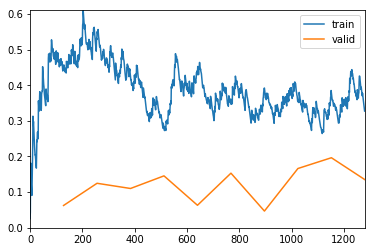

Better model found at epoch 0 with valid_loss value: 0.0625925064086914.
Better model found at epoch 6 with valid_loss value: 0.04695037007331848.


In [0]:
learn.precompute = False
learn.unfreeze()
lr = .5e-4
learn.fit_one_cycle(max_lr=slice((lr)/100, (lr)/10, lr/1), cyc_len=10, callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])

epoch,train_loss,valid_loss,accuracy,time
0,0.319745,0.111990,0.952381,00:22
1,0.378169,0.044449,1.000000,00:23
2,0.327706,0.150272,0.976190,00:23
3,0.353431,0.141556,0.976190,00:22
4,0.323709,0.093115,0.976190,00:22
5,0.311635,0.151465,0.928571,00:22
6,0.270148,0.144450,0.952381,00:22
7,0.423538,0.158654,0.952381,00:22
8,0.396984,0.263963,0.904762,00:22
9,0.395092,0.140506,0.976190,00:22


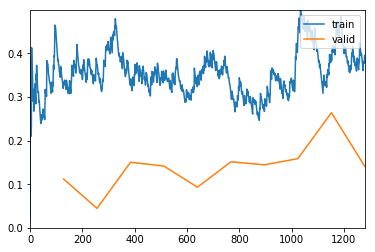

Better model found at epoch 0 with valid_loss value: 0.11199027299880981.
Better model found at epoch 1 with valid_loss value: 0.044449131935834885.


In [0]:
learn.precompute = False
learn.unfreeze()
lr = .5e-5
learn.fit_one_cycle(max_lr=slice((lr)/100, (lr)/10, lr/1), cyc_len=10, callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])

In [0]:
learn.save(data_root + '000')
learn.load(data_root + '000');

epoch,train_loss,valid_loss,accuracy,time
0,0.521822,0.128352,0.952381,00:22
1,0.356388,0.164053,0.928571,00:23
2,0.436609,0.248799,0.857143,00:22
3,0.304599,0.147204,0.952381,00:22
4,0.382280,0.235470,0.904762,00:22
5,0.426048,0.085474,0.976190,00:22
6,0.366960,0.097988,0.976190,00:23
7,0.356446,0.061956,1.000000,00:22
8,0.373369,0.138772,0.952381,00:23
9,0.347962,0.041551,1.000000,00:22


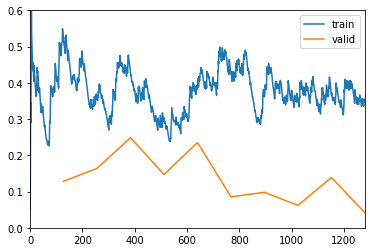

Better model found at epoch 0 with valid_loss value: 0.12835204601287842.
Better model found at epoch 5 with valid_loss value: 0.08547430485486984.
Better model found at epoch 7 with valid_loss value: 0.0619564950466156.
Better model found at epoch 9 with valid_loss value: 0.04155059531331062.


In [0]:
learn.precompute = False
learn.unfreeze()
lr = .5e-6
learn.fit_one_cycle(max_lr=slice((lr)/100, (lr)/10, lr/1), cyc_len=10, callbacks=[(callbacks.tracker.SaveModelCallback(learn, monitor='valid_loss', mode='min'))])

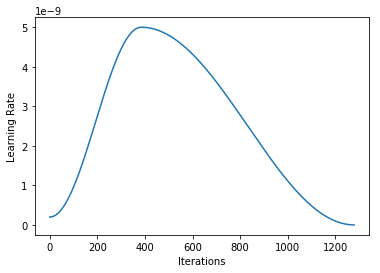

In [0]:
learn.recorder.plot_lr()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses, idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

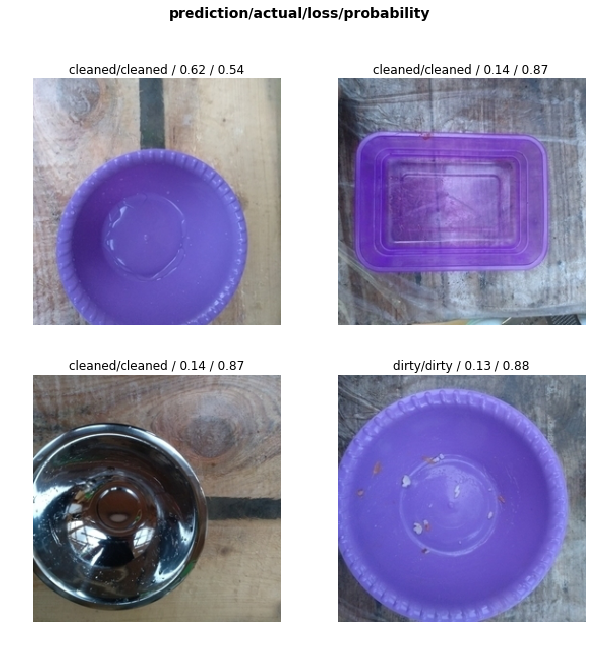

In [0]:
interp.plot_top_losses(4, figsize=(10,10), heatmap=False)

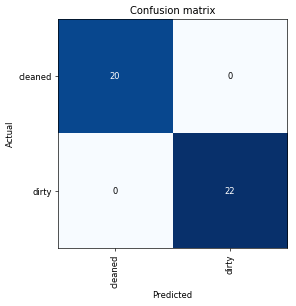

In [0]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=60)

In [0]:
learn.save(data_root + '000')


In [0]:
#learn.load(data_root + '962');
#learn.to_fp32();

In [0]:
log_preds, y = learn.TTA(ds_type=DatasetType.Test)
log_preds.shape

torch.Size([744, 2])

In [0]:
#log_preds[:,1][:19]

In [0]:
np.save(data_root + 'prob_sqviz3', log_preds[:,1])

In [0]:
#os.listdir(data_root)

In [0]:
sample_submission = pd.read_csv(data_root + 'sample_submission.csv')

In [0]:
sample_submission.head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [0]:
treshold = .5

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
fnames[:5]

['0151', '0044', '0041', '0208', '0010']

In [0]:
submission = pd.DataFrame({'id':fnames, 'label':log_preds[:,1]}, columns=['id', 'label'],)
submission.head(3)

,id,label
0,0151,0.886607
1,0044,0.922337
2,0041,0.832563


In [0]:
submission = submission.sort_values(by=['id']).reset_index(drop=True)

In [0]:
labels = pd.Series(['dirty' for i in range(submission.shape[0])])

In [0]:
labels.head()

0    dirty
1    dirty
2    dirty
3    dirty
4    dirty
dtype: object

In [0]:
labels[submission.label < treshold] = 'cleaned'

In [0]:
labels.head()

0      dirty
1      dirty
2    cleaned
3      dirty
4      dirty
dtype: object

In [0]:
sample_submission.label = labels
sample_submission.set_index('id', inplace=True)
sample_submission.head(20)

,label
id,
0,dirty
1,dirty
2,cleaned
3,dirty
4,dirty
5,dirty
6,dirty
7,dirty
8,dirty


In [0]:
sample_submission.to_csv( data_root +  'new-sub.csv')

In [0]:
8

8

## Blend

In [0]:
pr1 = np.load(data_root + '962-2.npy')
pr2 = np.load(data_root + '961.npy')
pr3 = np.load(data_root + '962.npy')

In [0]:
mean_all = np.mean(np.array([pr1, pr2, pr3]), 0)

In [0]:
mean_all

In [0]:
#mean_all = pr1

In [0]:
#blend = pd.read_csv(data_root + 'sample_submission.csv', index_col=0)

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
blend = pd.DataFrame({'id':fnames, 'label':mean_all}, columns=['id', 'label'],)
blend.head(3)

In [0]:
blend = blend.sort_values(by=['id']).reset_index(drop=True)

In [0]:
blend.set_index('id', inplace=True)

blend.head(10)

In [0]:
treshold = .5

In [0]:
blend.label[blend.label < treshold] = 'cleaned'
blend.label[blend.label  != 'cleaned'] = 'dirty'

In [0]:
blend.head(10)

In [0]:
blend.to_csv( data_root +  'blend.csv')